<a href="https://colab.research.google.com/github/EddyGiusepe/NLP_with_Disaster_Tweets_Transfer_Learning/blob/main/3_Transfer_Learning_in_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Text Classification - Transfer Learning</h2>


Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

# <font color="orange">Transfer Learning</font>

Está técnica permite treinar Redes Neurais de maneira mais rápida, com pouco requisito computacional e permitindo o treinamento da Rede com melhor desempenho e com poucos Dados.

A ideia comsiste em treinar uma Rede Neural em um Dataset grande, com grandes recursos computacionais e uma vez treinada utilizar o conhecimento que este modelo já possui como ponto de partida para nosso caso particular no processo conocido como `Fine-Tuning`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchtext==0.10.0

In [ ]:
# Importamos a nossas bibliotecas necessárias

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


import torchtext
from torchtext.legacy.data import Field, LabelField
from torchtext.legacy import data

In [ ]:
PATH = Path('/content/drive/MyDrive/5_Scripts_in_Python_Eddy/3_SENSIO_ML_DL/Kaggle_NLP_with_Disaster_Tweets/data_Tweets')

os.listdir(PATH)


['sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_clean.csv',
 'test_clean.csv',
 'submission.csv']

In [ ]:
# A diferença do outro script vamos a usar o total dos Dados

ID = data.RawField()
KEYWORD = data.RawField()
LOCATION = data.RawField()
TEXT = data.Field(tokenize="spacy")
LABEL = data.LabelField(dtype = torch.long)

dataset = data.TabularDataset(
    path = PATH / 'train.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT), ('target', LABEL)],
    skip_header = True
)

len(dataset)

7613

In [ ]:
ix = 0

print(vars(dataset.examples[ix]))

{'id': '1', 'keyword': '', 'location': '', 'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': '1'}


In [ ]:
train_dataset, valid_dataset = dataset.split(
    split_ratio=0.75,
    stratified=True,
    strata_field='target'
)

len(train_dataset), len(valid_dataset)

(5709, 1904)

In [ ]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_dataset, 
                 max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d", # Aqui vai baixar estes vetores de Embeddings (tem 100 DIMENSÕES)
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_dataset)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 24743.61it/s]


In [ ]:
len(TEXT.vocab), len(LABEL.vocab)

(10002, 2)

In [ ]:

TEXT.vocab.itos[:10]


['<unk>', '<pad>', '#', '.', '?', 'the', ':', 'a', 'to', 'in']

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': data.BucketIterator(valid_dataset, batch_size=100, device=device)
}

In [ ]:
# OBS: embedding_dim=100 --> Tem que ser 100 porque é o tamanho dos Embeddings pré-treinados

class LSTM(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=100, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=True, dropout=0):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_outputs)
        
    def forward(self, text):
      with torch.no_grad(): # Para ter certeza que não vamos treinar os Embeddings da Rede que estamos aproveitando 
        embedded = self.embedding(text)
      output, _ = self.rnn(embedded)
      # [l, bs, h]
      return self.fc(output[-1,:,:].squeeze(0))

In [ ]:
model = LSTM(input_dim=len(TEXT.vocab))

# Testamos o funcionamento de nosso Modelo, passando um Tensor de prova
output = model(torch.randint(0, len(TEXT.vocab), (100, 64)))

output.shape

torch.Size([64, 2])

In [ ]:
import sklearn.metrics as m

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        for batch in dataloader['train']:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad(): 
            for batch in dataloader['val']:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [ ]:
model = LSTM(input_dim=len(TEXT.vocab))


pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(100)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(100)


hist = fit(model, dataloader) 

# Observamos que o desempenho do modelo melhorou porque aplicamos a Técnica de Transfer Learning (Aproveitamos o conhecimento de outra Rede) 

Epoch 1/10 loss 0.67876 f1 0.00698 val_loss 0.64197 val_f1 0.26135
Epoch 2/10 loss 0.65927 f1 0.43145 val_loss 0.65724 val_f1 0.44752
Epoch 3/10 loss 0.66089 f1 0.37708 val_loss 0.66466 val_f1 0.27139
Epoch 4/10 loss 0.65102 f1 0.39870 val_loss 0.64086 val_f1 0.67652
Epoch 5/10 loss 0.60733 f1 0.58135 val_loss 0.53025 val_f1 0.67981
Epoch 6/10 loss 0.50205 f1 0.70078 val_loss 0.50392 val_f1 0.68449
Epoch 7/10 loss 0.42721 f1 0.77161 val_loss 0.48009 val_f1 0.71792
Epoch 8/10 loss 0.37843 f1 0.81053 val_loss 0.51406 val_f1 0.73623
Epoch 9/10 loss 0.35918 f1 0.82089 val_loss 0.46753 val_f1 0.76025
Epoch 10/10 loss 0.29582 f1 0.86708 val_loss 0.48153 val_f1 0.75880


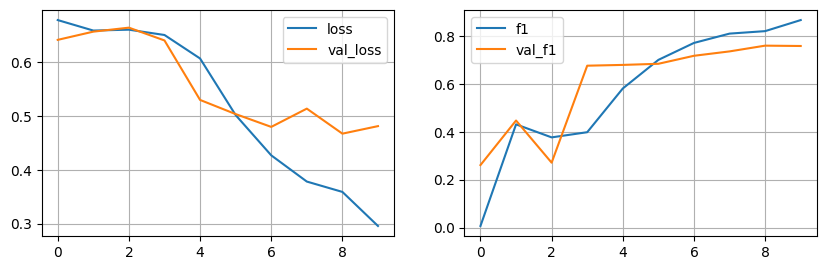

In [ ]:
def plot(hist):
    fig = plt.figure(dpi=100,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

## Agora nos Dados de Test

In [ ]:
test_dataset = data.TabularDataset(
    path = PATH / 'test.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT)],
    skip_header = True
)

len(test_dataset)

3263

In [ ]:
ix = 3258

print(vars(test_dataset.examples[ix]))

{'id': '10861', 'keyword': '', 'location': '', 'text': ['EARTHQUAKE', 'SAFETY', 'LOS', 'ANGELES', '\x89ÛÒ', 'SAFETY', 'FASTENERS', 'XrWn']}


In [ ]:
test_dataloader = data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)

In [ ]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in test_dataloader:
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [ ]:
preds = predict()

preds

tensor([1., 1., 0.,  ..., 1., 1., 1.])

In [ ]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
submission.target = preds.cpu().long()
submission

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv('submission.csv', index=False)